# Project : Build a Research Agent with LangGraph, GPT-4o, RAG, Pinecone, Arxiv and Google SerpAPI

### Extracting Data from Arxiv into a Pandas DataFrame and Saving it as JSON

In [1]:
pip install -q -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET

#namespace for ArXiv's Atom-based XML format.
ARXIV_NAMESPACE = '{http://www.w3.org/2005/Atom}'

def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='files/arxiv_dataset.json'):
    """
    Fetches papers from the ArXiv API based on a search qurery, saves them as JSON,
    and returns a pandas DataFrame.

    Args :
        serarch_query (str) : The serarch quyery for ArXiv (default is 'cat:cs.AI').
        max_results (int) : The maximum number of results to retrieve (default is 100).
        json_file_path (str) : File path where JSON data will be saved.

    Returns :
       pd.DataFrame : DataFrame containing the extracted paper information. 
    """

    # Construct the URL for the API request.
    url = f'http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}'

    # Send a GET request to the ArXiv API.
    response = requests.get(url)

    # Parse the XML response.
    root = ET.fromstring(response.content)

    # To store all extracted paper data
    papers = []

    # Loop through each 'entry' in the XML, representing a single paper.
    for entry in root.findall(f'{ARXIV_NAMESPACE}entry'):
        title = entry.find(f'{ARXIV_NAMESPACE}title').text.strip()
        summary = entry.find(f'{ARXIV_NAMESPACE}summary').text.strip()

        # Get the authors of the paper.
        author_element = entry.findall(f'{ARXIV_NAMESPACE}author')
        authors = [a.find(f'{ARXIV_NAMESPACE}name').text for a in author_element]

        # Get the paper's URL.
        paper_url = entry.find(f'{ARXIV_NAMESPACE}id').text
        arxiv_id = paper_url.split('/')[-1]

        # Check for the PDF link.
        pdf_link = next((link.attrib["href"] for link in entry.findall(f'{ARXIV_NAMESPACE}link')
                         if link.attrib.get("title") == "pdf"), None)

        papers.append({
            "title": title,
            "summary": summary,
            "authors": authors,
            "arxiv_id": arxiv_id,
            "url": paper_url,
            "pdf_link": pdf_link
        })

    # Convert list into a pandas DataFrame.
    df = pd.DataFrame(papers)

    # Save the DataFrame to a JSON file.
    with open(json_file_path, "w", encoding="utf-8") as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f"Data saved to {json_file_path} ...")
    
    return df

In [3]:
#if arxiv_dataset.json already present in files folder do not run this.
df = extract_from_arxiv(max_results=20)

Data saved to files/arxiv_dataset.json ...


In [4]:
# if you want to load the data from JSON file.
import json
file_name = 'files/arxiv_dataset.json'
with open(file_name,'r') as f:
    data = json.load(f)
print(data)

[{'title': 'A Deep Reinforcement Learning Approach for Ramp Metering Based on Traffic Video Data', 'summary': 'Ramp metering that uses traffic signals to regulate vehicle flows from the on-ramps has been widely implemented to improve vehicle mobility of the freeway. Previous studies generally update signal timings in real-time based on predefined traffic measures collected by point detectors, such as traffic volumes and occupancies. Comparing with point detectors, traffic cameras-which have been increasingly deployed on road networks-could cover larger areas and provide more detailed traffic information. In this work, we propose a deep reinforcement learning (DRL) method to explore the potential of traffic video data in improving the efficiency of ramp metering. The proposed method uses traffic video frames as inputs and learns the optimal control strategies directly from the high-dimensional visual inputs. A real-world case study demonstrates that, in comparison with a state-of-the-pr

In [5]:
# if you prefer to work as a pandas data frame.
import pandas as pd
df = pd.DataFrame(data)
df.sample(5) #-> this will display 5 random rows from data
# df #-> this will display all the rows

,title,summary,authors,arxiv_id,url,pdf_link
8,Dynamic-K Recommendation with Personalized Dec...,"In this paper, we investigate the recommendati...","[Yan Gao, Jiafeng Guo, Yanyan Lan, Huaming Liao]",2012.13569v1,http://arxiv.org/abs/2012.13569v1,https://arxiv.org/pdf/2012.13569v1
18,Feature Selection and Feature Extraction in Pa...,Pattern analysis often requires a pre-processi...,"[Benyamin Ghojogh, Maria N. Samad, Sayema Asif...",1905.02845v1,http://arxiv.org/abs/1905.02845v1,https://arxiv.org/pdf/1905.02845v1
13,My Teacher Thinks The World Is Flat! Interpret...,Significant progress has been made in deep-lea...,"[Swapnil Parekh, Yaman Kumar Singla, Changyou ...",2012.13872v1,http://arxiv.org/abs/2012.13872v1,https://arxiv.org/pdf/2012.13872v1
14,Neural document expansion for ad-hoc informati...,"Recently, Nogueira et al. [2019] proposed a ne...","[Cheng Tang, Andrew Arnold]",2012.14005v1,http://arxiv.org/abs/2012.14005v1,https://arxiv.org/pdf/2012.14005v1
19,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,https://arxiv.org/pdf/1905.01984v1


### Downloading the Resesearch Papers (PDFs)

In [8]:
import requests
import os

def download_pdfs(df, download_folder='files'):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specific folder.
    The file names are stored in a new column 'pdf_file_name' in the DataFrame.

    Args :
        df (pd.DataFrame) : DataFrame containing a 'pdf_link' column with URLs to download.
        download_folder (str) : Path to the folder where PDFs will be saved (default is 'files').

    Returns :
        pd.DataFrame : The original DataFrame with an additional 'pdf_file_name' coumn containing
                the paths of the downloaded PDF files or None if the download failed.
    """
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    pdf_file_names = []
    
    for _, row in df.iterrows():
        link = row["pdf_link"]
        try:
            response = requests.get(link)
            response.raise_for_status()
            file_name = os.path.join(download_folder, link.split("/")[-1]) + ".pdf"
            pdf_file_names.append(file_name)
            
            with open(file_name, "wb") as f:
                f.write(response.content)
            
            print(f"PDF downloaded and saved as {file_name}")
            
        except requests.exceptions.RequestException as e:
            pdf_file_names.append(None)
            print(f"Download failed: {e}")

    df["pdf_file_name"] = pdf_file_names
    return df

In [9]:
df = download_pdfs(df)

PDF downloaded and saved as files\2012.12104v1.pdf
PDF downloaded and saved as files\2012.13026v1.pdf
PDF downloaded and saved as files\2012.13293v1.pdf
PDF downloaded and saved as files\2012.13315v1.pdf
PDF downloaded and saved as files\2012.13391v2.pdf
PDF downloaded and saved as files\2012.12447v1.pdf
PDF downloaded and saved as files\2012.12634v1.pdf
PDF downloaded and saved as files\2012.11903v1.pdf
PDF downloaded and saved as files\2012.13569v1.pdf
PDF downloaded and saved as files\2012.12718v1.pdf
PDF downloaded and saved as files\2012.13666v1.pdf
PDF downloaded and saved as files\2012.13677v1.pdf
PDF downloaded and saved as files\2012.13779v1.pdf
PDF downloaded and saved as files\2012.13872v1.pdf
PDF downloaded and saved as files\2012.14005v1.pdf
PDF downloaded and saved as files\1904.07934v2.pdf
PDF downloaded and saved as files\1904.08010v1.pdf
PDF downloaded and saved as files\1905.02810v1.pdf
PDF downloaded and saved as files\1905.02845v1.pdf
PDF downloaded and saved as fil

In [10]:
df

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,https://arxiv.org/pdf/2012.12104v1,files\2012.12104v1.pdf
1,Rethink AI-based Power Grid Control: Diving In...,"Recently, deep reinforcement learning (DRL)-ba...","[Xiren Zhou, Siqi Wang, Ruisheng Diao, Desong ...",2012.13026v1,http://arxiv.org/abs/2012.13026v1,https://arxiv.org/pdf/2012.13026v1,files\2012.13026v1.pdf
2,Fuzzy Commitments Offer Insufficient Protectio...,"In this work, we study the protection that fuz...","[Danny Keller, Margarita Osadchy, Orr Dunkelman]",2012.13293v1,http://arxiv.org/abs/2012.13293v1,https://arxiv.org/pdf/2012.13293v1,files\2012.13293v1.pdf
3,Generalization in portfolio-based algorithm se...,Portfolio-based algorithm selection has seen t...,"[Maria-Florina Balcan, Tuomas Sandholm, Ellen ...",2012.13315v1,http://arxiv.org/abs/2012.13315v1,https://arxiv.org/pdf/2012.13315v1,files\2012.13315v1.pdf
4,"I like fish, especially dolphins: Addressing C...",To quantify how well natural language understa...,"[Yixin Nie, Mary Williamson, Mohit Bansal, Dou...",2012.13391v2,http://arxiv.org/abs/2012.13391v2,https://arxiv.org/pdf/2012.13391v2,files\2012.13391v2.pdf
5,Skeleton-based Approaches based on Machine Vis...,"Recently, skeleton-based approaches have achie...","[Jie Li, Binglin Li, Min Gao]",2012.12447v1,http://arxiv.org/abs/2012.12447v1,https://arxiv.org/pdf/2012.12447v1,files\2012.12447v1.pdf
6,Overview of FPGA deep learning acceleration ba...,"In recent years, deep learning has become more...",[Simin Liu],2012.12634v1,http://arxiv.org/abs/2012.12634v1,https://arxiv.org/pdf/2012.12634v1,files\2012.12634v1.pdf
7,Modelling Human Routines: Conceptualising Soci...,Our routines play an important role in a wide ...,"[Rijk Mercuur, Virginia Dignum, Catholijn M. J...",2012.11903v1,http://arxiv.org/abs/2012.11903v1,https://arxiv.org/pdf/2012.11903v1,files\2012.11903v1.pdf
8,Dynamic-K Recommendation with Personalized Dec...,"In this paper, we investigate the recommendati...","[Yan Gao, Jiafeng Guo, Yanyan Lan, Huaming Liao]",2012.13569v1,http://arxiv.org/abs/2012.13569v1,https://arxiv.org/pdf/2012.13569v1,files\2012.13569v1.pdf
9,Compliance Generation for Privacy Documents un...,Most prominent research today addresses compli...,"[David Restrepo Amariles, Aurore ClÃ©ment Trou...",2012.12718v1,http://arxiv.org/abs/2012.12718v1,https://arxiv.org/pdf/2012.12718v1,files\2012.12718v1.pdf


### Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

In [11]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_and_chunk_pdf(pdf_file_name, chunk_size=512):
    """
    Loads a PDF file and splits its content into chunks of a specified size.

    Args :
        file (str) : Path to the PDF file to be loaded.
        chunk_size (int) : The maximum size of each chunk in characters (default is 512).

    Returns :
        List[Document] : A list of document chunks.
    """
    
    print(f"Loading: {pdf_file_name}")

    #load the content of the pdf
    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    # split the content into chunks with slight overlap to perserve context
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=64)
    chunks = splitter.split_documents(data)
    
    return chunks


In [12]:
def expand_df(df):
    """
    Expands each row in the DataFrame by splitting PDF documents into chunks.

    Args :
        df (pd.DataFrame) : DataFrame containing 'pdf_file_name','arxiv_id','title','summary',
                    'authors', and 'url' columns.
    Returns :
        pd.DataFrame : A new DataFrame where each row represents a chunk of the orginal document,
                       with additional metadata such as chunk identifiers and relationships to 
                       adjacent chunks.
    """
    expanded_rows = [] # list to store expanded rows with chunk information

    # loops through each row in DataFrame
    for _, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row["pdf_file_name"])
        except Exception as e:
            print("Chunk error:", e)
            continue

        # loop over the chunks and consturct a new DataFrame row for each
        for i, chunk in enumerate(chunks):
            pre = i - 1 if i > 0 else "" # Preceding chunk ID
            post = i + 1 if i < len(chunks) - 1 else "" # following chunk ID
            
            expanded_rows.append({
                "id": f"{row['arxiv_id']}#{i}", # Unique chunk identifier
                "title": row["title"],
                "summary": row["summary"],
                "authors": row["authors"],
                "arxiv_id": row["arxiv_id"],
                "url": row["url"],
                "chunk": chunk.page_content, # text content of the chunk 
                "prechunk_id": "" if i == 0 else f"{row['arxiv_id']}#{pre}", # Previous chunk ID
                "postchunk_id": "" if i == len(chunks)-1 else f"{row['arxiv_id']}#{post}", # Next chunk ID
            })

    # return a new expanded DataFrame
    return pd.DataFrame(expanded_rows)

In [13]:
expanded_df = expand_df(df)

Loading: files\2012.12104v1.pdf
Loading: files\2012.13026v1.pdf
Loading: files\2012.13293v1.pdf
Loading: files\2012.13315v1.pdf
Loading: files\2012.13391v2.pdf
Loading: files\2012.12447v1.pdf
Loading: files\2012.12634v1.pdf
Loading: files\2012.11903v1.pdf
Loading: files\2012.13569v1.pdf
Loading: files\2012.12718v1.pdf
Loading: files\2012.13666v1.pdf
Loading: files\2012.13677v1.pdf
Loading: files\2012.13779v1.pdf
Loading: files\2012.13872v1.pdf
Loading: files\2012.14005v1.pdf
Loading: files\1904.07934v2.pdf
Loading: files\1904.08010v1.pdf
Loading: files\1905.02810v1.pdf
Loading: files\1905.02845v1.pdf
Loading: files\1905.01984v1.pdf


In [14]:
expanded_df

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,2012.12104v1#0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,1 \nA Deep Reinforcement Learning Approach for...,,2012.12104v1#1
1,2012.12104v1#1,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,Abstract \nRamp metering that uses traffic sig...,2012.12104v1#0,2012.12104v1#2
2,2012.12104v1#2,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,and provide more detailed traffic information....,2012.12104v1#1,2012.12104v1#3
3,2012.12104v1#3,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,method results in 1) lower travel times in the...,2012.12104v1#2,2012.12104v1#4
4,2012.12104v1#4,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,2 \nIntroduction \nRamp metering uses traffic ...,2012.12104v1#3,2012.12104v1#5
...,...,...,...,...,...,...,...,...,...
2193,1905.01984v1#123,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,Topic aware neural response generation . In Th...,1905.01984v1#122,1905.01984v1#124
2194,1905.01984v1#124,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,Personalized response generation via domain ad...,1905.01984v1#123,1905.01984v1#125
2195,1905.01984v1#125,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,generative adversarial nets with policy gradie...,1905.01984v1#124,1905.01984v1#126
2196,1905.01984v1#126,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,pets too? arXiv preprint arXiv:1801.07243. \n...,1905.01984v1#125,1905.01984v1#127


### Building a Knowledge Base for the RAG System Using Embedding

In [15]:
from dotenv import load_dotenv,find_dotenv

load_dotenv(find_dotenv(),override=True)

True

In [21]:
import os
from getpass import getpass

import google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY") or getpass("Gemini API Key: ")
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Encoder  
from langchain_google_genai import GoogleGenerativeAIEmbeddings
encoder = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    output_dimensionality=1536  # closest vector size to OpenAI’s small
)

In [27]:
# test dimension
dims = len(encoder.embed_query("hello world"))
dims

3072

### Creating a Pinecone Index

In [28]:
from pinecone import Pinecone, ServerlessSpec

# Checking if pinecone API key is set prompt if not
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

#Initialize the Pinecone client
pc = Pinecone(api_key=api_key)

# Define the serverless specification for Pinecone (AWS region 'us-east-1' only free region available at the moment)
spec = ServerlessSpec(cloud="aws", region="us-east-1")

In [29]:
import time

# Define the name of the index
index_name = "langgraph-research-agent"

# Check if index exists, create if it doesn't
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name, 
        dimension=dims, 
        metric="cosine", 
        spec=spec
    )
    
    # Wait until the index if fully initialized
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

# Connect to the index
index = pc.Index(index_name)

# Add a short delay before checking the stats
time.sleep(1)

# View the index statistics
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '151',
                                    'content-type': 'application/json',
                                    'date': 'Sun, 04 Jan 2026 07:03:15 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '42',
                                    'x-pinecone-request-id': '7138995369059917325',
                                    'x-pinecone-request-latency-ms': '42',
                                    'x-pinecone-response-duration-ms': '43'}},
 'dimension': 3072,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'storageFullness': 0.0,
 'total_vector_count': 0,
 'vector_type': 'dense'}

### Populating the Knowledge Base and Uploading it to Pinecone

In [34]:
expanded_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,2012.12104v1#0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,1 \nA Deep Reinforcement Learning Approach for...,,2012.12104v1#1
1,2012.12104v1#1,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,Abstract \nRamp metering that uses traffic sig...,2012.12104v1#0,2012.12104v1#2
2,2012.12104v1#2,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,and provide more detailed traffic information....,2012.12104v1#1,2012.12104v1#3
3,2012.12104v1#3,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,method results in 1) lower travel times in the...,2012.12104v1#2,2012.12104v1#4
4,2012.12104v1#4,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,2 \nIntroduction \nRamp metering uses traffic ...,2012.12104v1#3,2012.12104v1#5


In [44]:
import time
from tqdm.auto import tqdm

batch_size = 32  # FREE tier safe

for i in tqdm(range(0, len(data), batch_size)):
    batch = data[i:i+batch_size].to_dict("records")

    ids = [x["id"] for x in batch]
    chunks = [x["chunk"] for x in batch]
    metadata = [{
        "arxiv_id": x["arxiv_id"],
        "title": x["title"],
        "chunk": x["chunk"]
    } for x in batch]

    try:
        embeds = encoder.embed_documents(chunks)
        index.upsert(vectors=zip(ids, embeds, metadata))
        time.sleep(0.7)  # steady pacing

    except Exception as e:
        if "Quota exceeded" in str(e) or "429" in str(e):
            print("⏳ Rate limit hit. Cooling down 60s...")
            time.sleep(60)
            continue   # let tqdm move on
        else:
            raise

print("✅ Indexing complete!")


  0%|          | 0/69 [00:00<?, ?it/s]

⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit hit. Cooling down 60s...
⏳ Rate limit

In [45]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '186',
                                    'content-type': 'application/json',
                                    'date': 'Sun, 04 Jan 2026 09:41:39 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '57',
                                    'x-pinecone-request-id': '4103824017793330728',
                                    'x-pinecone-request-latency-ms': '56',
                                    'x-pinecone-response-duration-ms': '58'}},
 'dimension': 3072,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'__default__': {'vector_count': 832}},
 'storageFullness': 0.0,
 'total_vector_count': 832,
 'vector_type': 'dense'}

### Implementing the ArXiv Fetch Tool

In [50]:
# this is how we get the webpage code (DEMO Code)
import requests
#specify the arXiv ID for the paper
arxiv_id = '1706.03762'

# Make a GET request to retrieve the page for the specified paper
res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

# Access the content of the response as a string (HTML)
res.text

'<!DOCTYPE html>\n<html lang="en">\n\n<head>  <title>[1706.03762] Attention Is All You Need</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <link rel="stylesheet" type="text/css" media="screen" href="/static/browse/0.3.4/css/arXiv.css?v=20241206" />\n  <link rel="stylesheet" type="text/css" media="print" href="/static/browse/0.3.4/css/a

In [51]:
# this is how we get the specific abstract from the page
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# Search for the abstract in the HTML response text
re_match = abstract_pattern.search(res.text)

# Check if the abstract was found and print it; otherwise, display an error message
if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found.')

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [52]:
## Actual tool Start here integrating what we have used above
import requests, re
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

from langchain_core.tools import tool

@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.
    
    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''
    res = requests.get(f"https://arxiv.org/abs/{arxiv_id}")
    m = abstract_pattern.search(res.text)
    return m.group(1) if m else "Abstract not found."



In [54]:
# Defining the ArXiv paper ID and invoking the toop with that ID
arxiv_id = "1706.03762"
output = fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
print(output)

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

### Integrating Google SerpAPI for Web Search

In [55]:
from dotenv import load_dotenv,find_dotenv

load_dotenv(find_dotenv(),override=True)

True

### Implementing the Web Search Tools with Google SerpAPI

In [56]:
# Practise code
from serpapi import GoogleSearch
import os
from getpass import getpass

# Set up the SerpAPI request parameters, including the API key.
serpapi_params = {
    'engine': 'google',  
    'api_key': os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')  # Get the API key securely.
}

# Perform a Google search for the keyword "water" and limit the results to 5.
search = GoogleSearch({
    **serpapi_params,
    'q': 'water',
    'num': 5
})


# Extract the main search results from the API response.
results = search.get_dict().get('organic_results', [])

# Format the search results for readability.
formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)


In [57]:
print(formatted_results)

Water
Water is an inorganic compound with the chemical formula H 2 O. It is a transparent, tasteless, odorless, [c] and nearly colorless chemical substance
https://en.wikipedia.org/wiki/Water
---
Waters Corporation | Laboratory Instruments, Consumables ...
Waters is the leading provider of lab equipment, supplies and software for scientists across the world. Easily research and order everything your lab needs!
https://www.waters.com/nextgen/us/en.html?srsltid=AfmBOopQS2vY9kU8YvZro8ASI7RYIKs-uxKzJeI60-DdSP0aulafyuhx
---
Tyla - Water (Official Music Video)
Tyla - Water (Official Music Video) Listen To “Water” now: https://Tyla.lnk.to/Water Watch the Official Music Video: ...
https://www.youtube.com/watch?v=XoiOOiuH8iI
---
Water | H2O | CID 962 - PubChem - NIH
Water appears as a clear, nontoxic liquid composed of hydrogen and oxygen, essential for life and the most widely used solvent.
https://pubchem.ncbi.nlm.nih.gov/compound/Water


In [58]:
# Actual tool
from serpapi import GoogleSearch

# Define the 'web_search' tool using the '@tool' decorator.
@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.
    
    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,  
        'q': query,        
        'num': 5         
    })
   
    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )
    
    # Return the formatted results or a 'No results found.' message if no results exist.
    return formatted_results if results else 'No results found.'

In [59]:
# Invoke the 'web_search' tool with the query 'water on mars'
output = web_search.invoke(input={'query': 'water on mars'})
print(output)

Water on Mars
Mars contains water, though mostly as subsurface permafrost. Surface water is readily visible at some places, such as the ice-filled Korolev Crater, near the ...
https://en.wikipedia.org/wiki/Water_on_Mars
---
NASA Confirms Evidence That Liquid Water Flows ...
New findings from NASA's Mars Reconnaissance Orbiter (MRO) provide the strongest evidence yet that liquid water flows intermittently on present-day Mars.
https://www.nasa.gov/news-release/nasa-confirms-evidence-that-liquid-water-flows-on-todays-mars/
---
Scientists find oceans of water on Mars. It's just too deep to ...
A new analysis of Mars' interior suggests that much of the liquid water still exists in the pores of rocks 10-20 kilometers below the surface.
https://news.berkeley.edu/2024/08/12/scientists-find-oceans-of-water-on-mars-its-just-too-deep-to-tap/
---
Scientists have discovered a reservoir of liquid water on Mars
While there is water frozen at the Martian poles and evidence of vapour in the atmosphere,

### Creating RAG Tools for Retrieval-Augmented Generation (RAG)

In [61]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.
    
    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted = []
    
    # Loop through each match and extract its metadata.
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        # Append each formatted string to the results list.
        formatted.append(text)
    
    # Join all the individual formatted strings into one large string.
    return '\n---\n'.join(formatted)

In [62]:
from langchain_core.tools import tool

@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder.embed_query(query)
    
    # Perform a search on the Pinecone index, filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={'arxiv_id': arxiv_id})
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

In [63]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder.embed_query(query)
    
    # Perform a broader search without filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=5, include_metadata=True)
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

### Implementing the Final Answer Generation Tool

In [64]:
from langchain_core.tools import tool

# Define the 'final_answer' tool to compile the research report.
@tool
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (str or list): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    # Format research steps if given as a list.
    if isinstance(research_steps, list):
        research_steps = "\n".join([f"- {x}" for x in research_steps])
    
    # Format sources if given as a list.
    if isinstance(sources, list):
        sources = "\n".join([f"- {x}" for x in sources])
    
    # Construct and return the final research report.
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'

### Initializing the Oracle LLM

In [70]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define the system prompt guiding the AI's decision-making process.
system_prompt = (
    '''You are the oracle, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.
    
    # Insert past chat messages to maintain context.
    MessagesPlaceholder("chat_history"),
    
    # Insert user's input dynamically.
    ('user', '{input}'),
    
    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [83]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import ToolCall, ToolMessage

# Initialize the OpenAI language model with specific settings.
llm = ChatGoogleGenerativeAI(
    # model="gemini-2.0-flash", # initially we are using this model but as our limit exceed we are changing it to below
    model="gemini-2.5-flash-lite",
    temperature=0,
    
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps):
    logs = []
    
    # Loop over each step and process tool calls with actual outputs.
    for action in intermediate_steps:
        if action.log != "TBD":
            logs.append(
                f"Tool: {action.tool}, input: {action.tool_input}\nOutput: {action.log}"
            )
    
    # Join the research steps into a readable log.
    return '\n---\n'.join(logs)

# Define the oracle's decision-making pipeline.
oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(x["intermediate_steps"]),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)


###  Testing the Oracle

In [90]:
# input = 'Tell me something interesting about dynamic backtracking AI and LLMs'
# input = 'Who won the Super Bowl 2025?'
input = 'What is the ArXiv paper with the ID 2407.21783 all about?'

# Create the inputs dictionary, containing the user's query and initial empty chat history and intermediate steps.
inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

# Invoke the oracle with the inputs, processing the query and returning a response.
out = oracle.invoke(inputs)

# Display the oracle's response.
print(out)


content='' additional_kwargs={'function_call': {'name': 'fetch_arxiv', 'arguments': '{"arxiv_id": "2407.21783"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--253eced9-2a58-46b1-a19b-4416b040d849-0' tool_calls=[{'name': 'fetch_arxiv', 'args': {'arxiv_id': '2407.21783'}, 'id': '5ba8f2c3-7f5a-47ae-b5ba-9df9ee72db49', 'type': 'tool_call'}] usage_metadata={'input_tokens': 778, 'output_tokens': 26, 'total_tokens': 804, 'input_token_details': {'cache_read': 0}}


In [91]:
# Display the name of the tool
out.tool_calls[0]['name']

'fetch_arxiv'

In [92]:
# Display the tool's arguments
out.tool_calls[0]['args']

{'arxiv_id': '2407.21783'}

### Building a Decision-Making Pipeline

In [93]:
# run_oracle(): main function that executes the oracle and processes its output to extract the relevant tool and its arguments.
# We'll use this information to update the state for future steps.
def run_oracle(state):
    '''Runs the oracle and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''
    
    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')
    
    # Invoke the oracle with the current state.
    out = oracle.invoke(state)

    # Extract the tool name and its arguments from the oracle's response.
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    # Create an AgentAction object, which records the tool used and the input provided.
    action  = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    # Return a new state with updated 'intermediate_steps'.
    return {
        'intermediate_steps': [action]
    }


# The router() function determines the next tool to use based on the current state.
def router(state):
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer,
}

# The run_tool() function executes the appropriate tool based on the current state.
def run_tool(state):
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state["intermediate_steps"][-1].tool
    tool_input = state["intermediate_steps"][-1].tool_input
    out = tool_str_to_func[tool_name].invoke(input=tool_input)
    action = AgentAction(tool=tool_name, tool_input=tool_input, log=str(out))
    return {"intermediate_steps": [action]}

### Defining Agent State

In [102]:
from typing import TypedDict, Annotated, List
import operator
from langchain_core.agents import AgentAction

class AgentState(TypedDict):
    '''Represents the state of an agent.'''
    input: str
    chat_history: List
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]


In [103]:
from langgraph.graph import StateGraph, END

# Initialize the state graph with AgentState to manage the workflow.
graph = StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

# Set the entry point to 'oracle'.
graph.set_entry_point('oracle')

# Add conditional edges to determine the next step using the router function.
graph.add_conditional_edges(source='oracle', path=router)

# Add edges from each tool back to 'oracle', except 'final_answer', which leads to 'END'.
for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

graph.add_edge('final_answer', END)

# Compile the graph to make it executable.
runnable = graph.compile()

### Defining the Graph for Decision-Making

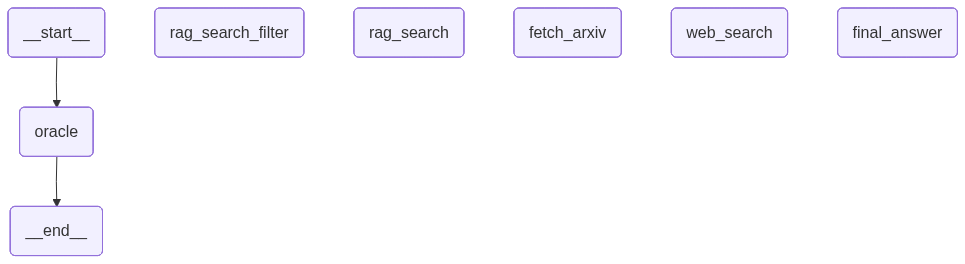

In [104]:
from IPython.display import Image, display

# Display the graph as a PNG using Mermaid rendering.
display(Image(runnable.get_graph().draw_mermaid_png()))

In [105]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

run_oracle
intermediate_steps: []
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: Rethink AI-based Power Grid Control: Diving Into Algorithm Design\nChunk: for t= 0,1,2...,tlimit −1 do\nat = π(st)\nst+1 ←perform at on st\nif st+1 ∈T or t+ 1 =tlimit then\nL= L∪{t+ 1}\nbreak\nreturn El∈L[l]\nInspired by the study in Section 4.3, an imitation learning method is proposed to train an agent with\nonly successful steps. Speciﬁcally, the proposed method does not incorporate any reinforcement\n4\nArXiv ID: 2012.13026v1\n\n---\nTitle: Rethink AI-based Power Grid Control: Diving Into Algorithm Design\nChunk: test set: 21/1000(2.1%) test set: 1\npolicy, mostly s ̸= s(i)\n0 (the case is not solved within one step.) E.g., say s = s(i)\n5 , training with\n(s(i)\n5 ,a(i)\n5 ), the agent is able to learn an a(i)\n0 which instantly solves

In [106]:
output['intermediate_steps'][-1].tool_input 

{'introduction': 'Dynamic Backtracking AI is a technique that has been explored in various AI domains, including power grid control and dialogue systems. While not directly synonymous with Large Language Models (LLMs), its principles can be relevant to improving LLM performance and addressing their limitations.',
 'sources': '[{"title": "Rethink AI-based Power Grid Control: Diving Into Algorithm Design", "url": "https://arxiv.org/pdf/2012.13026v1"}, {"title": "I like fish, especially dolphins: Addressing Contradictions in Dialogue Modeling", "url": "https://arxiv.org/pdf/2012.13391v2"}, {"title": "Dynamic Backtracking", "url": "https://www.jair.org/index.php/jair/article/view/10107"}]',
 'research_steps': '1. Searched for "Dynamic Backtracking AI" to understand its core concepts and applications.\n2. Searched for "Dynamic Backtracking AI and LLMs" to find direct connections or proposed integrations.\n3. Explored research papers related to Dynamic Backtracking in AI, specifically lookin

### Generating Reports: Building a Formatted Final Report

In [107]:
def build_report(output):
    '''Builds a formatted report based on the oracle's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    steps = output["research_steps"]
    if isinstance(steps, list):
        steps = "\n".join([f"- {x}" for x in steps])
        
    sources = output["sources"]
    if isinstance(sources, list):
        sources = "\n".join([f"- {x}" for x in sources])
        
    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
        """

In [108]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        Dynamic Backtracking AI is a technique that has been explored in various AI domains, including power grid control and dialogue systems. While not directly synonymous with Large Language Models (LLMs), its principles can be relevant to improving LLM performance and addressing their limitations.

        RESEARCH STEPS
        --------------
        1. Searched for "Dynamic Backtracking AI" to understand its core concepts and applications.
2. Searched for "Dynamic Backtracking AI and LLMs" to find direct connections or proposed integrations.
3. Explored research papers related to Dynamic Backtracking in AI, specifically looking for its application in areas that might inform LLM development.
4. Investigated the challenges faced by LLMs, such as generating contradictions, and how techniques like Dynamic Backtracking might offer solutions.

        REPORT
        ------
        Dynamic Backtracking is an algorithmic technique that has been 

In [109]:
output = runnable.invoke({
    'input': 'tell me about FIFA World Cup 26',
    'chat_history': []  
})

run_oracle
intermediate_steps: []
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026'}, log='FIFA World Cup 2026™\nThe FIFA World Cup 2026™ will be the 23rd edition of the tournament but the first to feature 48 teams and three host countries: Canada, Mexico and the ...\nhttps://www.fifa.com/en/tournaments/mens/worldcup/canadamexicousa2026\n---\n2026 FIFA World Cup\nThe tournament will take place from June 11 to July 19, 2026. ... It will be jointly hosted by sixteen cities—eleven in the United States, three in Mexico, and ...\nhttps://en.wikipedia.org/wiki/2026_FIFA_World_Cup')]
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026'}, log='FIFA World Cup 2026™\nThe FIFA World Cup 2026™ will be the 23rd edition

In [110]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        The FIFA World Cup 2026 will be the 23rd edition of the tournament and the first to be held in three host countries: Canada, Mexico, and the United States.

        RESEARCH STEPS
        --------------
        1. Searched for general information about the FIFA World Cup 2026. 
2. Searched for the host cities of the FIFA World Cup 2026.

        REPORT
        ------
        The FIFA World Cup 2026 is scheduled to take place from June 11 to July 19, 2026. This tournament will mark a significant expansion, being the first to feature 48 teams. The hosting duties will be shared by three North American nations: Canada, Mexico, and the United States. A total of sixteen cities will host the matches, with eleven located in the United States, three in Mexico, and two in Canada. Some of the host cities in the United States include Atlanta, Boston, Dallas, Houston, Kansas City, Los Angeles, Miami, and New York/New Jersey.

        CONCLUSION
   

In [111]:
output = runnable.invoke({
    'input': 'Create a summary about this AxXiv paper with the ID 2409.17990',
    'chat_history': []
})

run_oracle
intermediate_steps: []
run_oracle
intermediate_steps: [AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='TBD'), AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='This paper proposes temporally aligned Large Language Models (LLMs) as a tool for longitudinal analysis of social media data. We fine-tune Temporal Adapters for Llama 3 8B on full timelines from a panel of British Twitter users, and extract longitudinal aggregates of emotions and attitudes with established questionnaires. We focus our analysis on the beginning of the COVID-19 pandemic that had a strong impact on public opinion and collective emotions. We validate our estimates against representative British survey data and find strong positive, significant correlations for several collective emotions. The obtained estimates are robust across multiple training seeds and prompt formulations, and in line with collective emotions extracted using a traditional classific

In [112]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        This report summarizes the arXiv paper "Temporally Aligned Large Language Models for Longitudinal Analysis of Social Media Data" (ID: 2409.17990).

        RESEARCH STEPS
        --------------
        1. Fetched the abstract of the paper using the provided arXiv ID.
2. Extracted key information regarding the paper's methodology, findings, and contributions.

        REPORT
        ------
        The paper introduces a novel approach using temporally aligned Large Language Models (LLMs) for the longitudinal analysis of social media data. The researchers fine-tuned Temporal Adapters for Llama 3 8B on the complete timelines of British Twitter users. This allowed them to extract longitudinal aggregates of emotions and attitudes, which were then compared against established questionnaires.

The study focused on the initial phase of the COVID-19 pandemic, a period marked by significant shifts in public opinion and collective emotions. The L